## Step 1: Defining the Hamiltonian

The Hamiltonian for 2-level systems (including vibronic coupling) coupled to an N-level cavity (Holstein-Tavis-Cummings model) is:

\begin{equation}
H = \sum_i -\frac{\hbar \omega_i}{2} \sigma_{z,i} + \hbar \omega \hat{a}^\dagger \hat{a} +  \sum_i \hbar g_i ( \hat{a}  \sigma_{+,i} + \hat{a}^\dagger \sigma_{-,i} ) + \lambda \omega \sigma^+ \sigma^-( \hat{b}^{\dagger} + \hat{b} ) + \hbar \omega_v \hat{b}^{\dagger} \hat{b}
\end{equation}

We can model the following physical process as a way to implement the iSWAP gate between two molecules:

1. We consider an initial state with an excitation localized on molecule 1.  At $t=0$, only molecule 1 is coupled to the cavity, and the molecule and cavity exchange an excitation due to their interaction.  

2. After some time $T_1$, the coupling between molecule 1 and the cavity vanishes (because it's orientation unaligns from the cavity field, or perhaps it translates out of the cavity).

3. Also at $T_1$, molecule 2 couples to the cavity.  Due to the coupling between molecule 2 and the cavity, they exchange excitations until time $T_2$, at which time molecule 2 no longer couples to the cavity.

If $T_1$ and $T_2$ are designed properly, the exchange of excitation results in a bell state between the molecule 1 and molecule 2 subsystems:

$$ 
T_1 = \frac{\pi}{4g_1} 
$$

$$
T_2 = \frac{\pi}{2g_2}
$$

$$ |\Psi\rangle = \sqrt{\frac{1}{2}} \left(|g\rangle \otimes |e\rangle + |e\rangle \otimes |g \rangle  \right) $$


**Because we get information about the impact of cavity coupling on vibronic coupling from polaritonic
structure calculations (like QED-CI), it seems natural to represent the coupled molecule-cavity 
systems in the polariton basis and then introduce the vibronic coupling by on top of this representation.**

This example will attempt the execution of an iSWAP in this fashion without any vibrational states.
We will perform the simulation both in the polariton basis and the uncoupled basis to show that they 
can give the same results.  This notebook uses only `numpy`, you should try to follow the implementation in `qutip`.

### Uncoupled basis
If we truncate the photonic states at $|1\rangle$ and each qubit's vibrational state at $|1\rangle$, we can represent the uncoupled basis as
$$ |0\rangle \otimes |g\rangle \otimes |0\rangle \otimes  |g\rangle \otimes |0\rangle, \; \\
   |0\rangle \otimes |g\rangle \otimes |0\rangle \otimes  |g\rangle \otimes |1\rangle, \; \\
   |0\rangle \otimes |g\rangle \otimes |0\rangle \otimes  |e\rangle \otimes |0\rangle, \; \\
   |0\rangle \otimes |g\rangle \otimes |0\rangle \otimes  |e\rangle \otimes |1\rangle, \; \\
   |0\rangle \otimes |g\rangle \otimes |1\rangle \otimes  |g\rangle \otimes |0\rangle, \; \\
   |0\rangle \otimes |g\rangle \otimes |1\rangle \otimes  |g\rangle \otimes |1\rangle, \; \\
   |0\rangle \otimes |g\rangle \otimes |1\rangle \otimes  |e\rangle \otimes |0\rangle, \; \\
   |0\rangle \otimes |g\rangle \otimes |1\rangle \otimes  |e\rangle \otimes |1\rangle, \; \\
   |0\rangle \otimes |e\rangle \otimes |0\rangle \otimes  |g\rangle \otimes |0\rangle, \;
...
$$




In [2]:
import numpy as np
import scipy.linalg as la

# Define the bosonic basis states truncated at n = 1 (for cavity and vibrational modes)
z_ket = np.array([[1], [0]])  # |0> as a column vector
o_ket = np.array([[0], [1]])  # |1> as a column vector

# Define the two-level atomic states
g_ket = np.array([[1], [0]])  # |g> as a column vector (ground state of the atom)
e_ket = np.array([[0], [1]])  # |e> as a column vector (excited state of the atom)


Let's set up the basis for the Holstein-Tavis-Cummings model.  We will define a helper function that will take the tensor product between multiple basis kets, then we will perform a loop over each subspace to systematically build the basis from all sub-states.  We will also generate labels for later use.

In [ ]:
def tensor(*args):
    """Kronecker product of multiple kets."""
    result = args[0]
    for a in args[1:]:
        result = np.kron(result, a)
    return result



# Labels for each local Hilbert space
boson_labels = ["0", "1"]   # truncated Fock states
qubit_labels = ["g", "e"]


In [4]:
basis = []
labels = []

for cav_i, cav in enumerate([z_ket, o_ket]):
    for q1_i, q1 in enumerate([g_ket, e_ket]):
        for v1_i, v1 in enumerate([z_ket, o_ket]):
            for q2_i, q2 in enumerate([g_ket, e_ket]):
                for v2_i, v2 in enumerate([z_ket, o_ket]):
                    
                    # State vector
                    state = tensor(cav, q1, v1, q2, v2)
                    basis.append(state)
                    
                    # String label
                    label = f"|{boson_labels[cav_i]}, {qubit_labels[q1_i]}, {boson_labels[v1_i]}, {qubit_labels[q2_i]}, {boson_labels[v2_i]}>"
                    labels.append(label)


The next cell defines some helper functions that we can use to run the simulation and (if desired), 
print various quantities with nice formating.

## Liouville Equation Solver
Similar to `qutips` mesolve, I have implemented a method that solves the Liouville equation of motion for the density matrix using a 4th-order Runge-Kutta algorithm.  The Lioville equation gives how a given quantum state, represented by a density matrix, evoles with time:

$$ i \hbar \frac{\partial}{\partial t} D = [H, D] $$

where $H$ is a matrix representation of the Hamiltonian and $D$ is the density matrix defined as 

$$ D = |\Psi \rangle \langle \Psi | $$

In [5]:
# Function to compute the expectation value of the Hamiltonian for a given state
def compute_expectation_value(state, H):
    return np.vdot(state, H @ state)

def print_operator_action(op, ket, op_name="Operator", ket_name="Ket"):
    """ prints the action of an operator on a ket in a formatted way """
    result = op @ ket

    # Formatters
    fmt = {'all': lambda x: f"{x: 6.3f}"}

    print(f"\n=== {op_name} acting on {ket_name} ===\n")

    print(f"{op_name} matrix in tensor product space:")
    print(np.array2string(op, formatter=fmt))

    print(f"\n{ket_name} vector in tensor product space:")
    print(np.array2string(ket.reshape(-1, 1), formatter=fmt))

    print(f"\nResulting vector in tensor product space ({op_name} ⋅ {ket_name}):")
    print(np.array2string(result.reshape(-1, 1), formatter=fmt))

def represent_basis_in_eigen(basis_names, eigvecs, energies=None, tol=1e-6):
    """
    For each original basis state |b_j>, prints its expansion
      |b_j> = sum_i c_{j,i} |ψ_i>
    where c_{j,i} = <ψ_i|b_j> = conj(eigvecs[j, i]) for a unitary eigvecs.
    
    Parameters
    ----------
    basis_names : list of str
        Names of the basis kets in the same order as the rows of eigvecs.
    eigvecs : np.ndarray, shape (N, N)
        Columns are the eigenvectors |ψ_i> expressed in the original basis.
    energies : array-like, optional
        If provided, labels the eigenstates by energy order.
    tol : float
        Threshold below which coefficients are treated as zero.
    """
    N = eigvecs.shape[0]
    assert eigvecs.shape == (N, N)
    assert len(basis_names) == N

    # If energies given, label states by E; otherwise by index
    labels = []
    if energies is not None:
        for i, E in enumerate(energies, 1):
            labels.append(f"ψ_{i} (E={E:.4f})")
    else:
        labels = [f"ψ_{i}" for i in range(1, N+1)]

    for j, name in enumerate(basis_names):
        # coefficients c_{j,i} = <ψ_i|b_j> = conj(eigvecs[j,i])
        coefs = np.conj(eigvecs[j, :])
        terms = []
        for i, c in enumerate(coefs):
            if abs(c) < tol:
                continue
            # format complex; drop imaginary part if ~0
            if abs(c.imag) < tol:
                terms.append(f"{c.real:+.4f}·|{labels[i]}>")
            else:
                terms.append(f"({c.real:+.4f}{c.imag:+.4f}j)·|{labels[i]}>")
        combo = "  +  ".join(terms) if terms else "0"
        print(f"|{name}> = {combo}\n")

# simple function for printing real part of complex matrix
def complex_formatter(x):
    return f"{x.real: .2f}" #{x.imag:+.2f}j"

def commutator(A, B):
    """Compute the commutator [A, B] = AB - BA"""
    return A @ B - B @ A

def liouville_rhs(H, rho, hbar=1.0):
    """Compute the right-hand side of the Liouville-von Neumann equation: -i/hbar * [H, rho]"""
    return -1j / hbar * commutator(H, rho)

def rk4_step(rho, H, dt, hbar=1.0):
    """
    Apply a single RK4 step to evolve the density matrix rho using a time-independent Hamiltonian H.

    Parameters:
    - rho: numpy.ndarray, the current density matrix
    - H: numpy.ndarray, the time-independent Hamiltonian
    - dt: float, time step
    - hbar: float, Planck's reduced constant (default = 1.0)

    Returns:
    - rho_next: numpy.ndarray, the updated density matrix after one time step
    """
    k1 = liouville_rhs(H, rho, hbar)
    k2 = liouville_rhs(H, rho + 0.5 * dt * k1, hbar)
    k3 = liouville_rhs(H, rho + 0.5 * dt * k2, hbar)
    k4 = liouville_rhs(H, rho + dt * k3, hbar)

    rho_next = rho + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return rho_next



## Step 2: Constructing the Hamiltonian

We'll now set up the Hamiltonian matrix in the uncoupled basis.

In [72]:

# Define the Hamiltonian parameters
omega_0 = 1.0  # Atomic frequency (in arbitrary units)
omega = 1.0    # Cavity frequency (in arbitrary units)
omega_vib = 0.1  # Vibrational frequency (in arbitrary units)
lambda_vib = 0.1 # Vibrational coupling strength (in arbitrary units)
g = 0.1        # Coupling strength (in arbitrary units)
hbar = 1.0     # Reduced Planck's constant (set to 1 for simplicity)


# Define the Pauli matrices for the atom Hilbert space (N = 2)
sigma_z = np.array([[1, 0], [0, -1]])
sigma_minus = np.array([[0, 1], [0, 0]])  # this is defined such that sigma_minus |e> = |g>
sigma_plus = np.array([[0, 0], [1, 0]])   # this is defined such that sigma_plus |g> = |e>

# Define the creation and annihilation operators for the cavity Hilbert space (N=2)
a = np.array([[0, 1], [0, 0]])                # annihilation operator, defined such that a |1> = |0>
a_dagger = np.array([[0, 0], [1, 0]])         # creation operator, defined such that a_dagger |0> = |1>

# Define the creation and annihilation operators for the vibrational Hilbert space (N=2)
b = np.array([[0, 1], [0, 0]])                # annihilation operator, defined such that a |1> = |0>
b_dagger = np.array([[0, 0], [1, 0]])         # creation operator, defined such that a_dagger |0> = |1>

# create identities for each Hilbert space
Icav = np.eye(2)
Iq   = np.eye(2)
Iv = np.eye(2)  # identity for the vibrational mode of molecule 1 and 2


# create cavity operators in composite Hilbert space
ap = tensor(a_dagger, Iq, Iv, Iq, Iv) # creation operator for the cavity
am = tensor(a, Iq, Iv, Iq, Iv)         # annihilation operator for the cavity

# create vibrational operator 1 in composite Hilbert space
bp1 = tensor(Icav, Iq, b_dagger, Iq, Iv) # creation operator for vibrational mode of molecule 1
bm1 = tensor(Icav, Iq, b, Iq, Iv) # annihilation operator for vibrational mode of molecule 1

# create vibrational operator 2 in composite Hilbert space
bp2 = tensor(Icav, Iq, Iv, Iq, b_dagger) # creation operator for vibrational mode of molecule 2
bm2 = tensor(Icav, Iq, Iv, Iq, b) # annihilation operator for vibrational mode of molecule 2

# create qubit operators in composite Hilbert space
sz1 = tensor(Icav, sigma_z, Iv, Iq, Iv) # sz on qubit 1
sz2 = tensor(Icav, Iq, Iv, sigma_z, Iv) # sz on qubit 2
sp1 = tensor(Icav, sigma_plus, Iv, Iq, Iv) # sp on qubit 1
sm1 = tensor(Icav, sigma_minus, Iv, Iq, Iv) # sm on qubit 1
sp2 = tensor(Icav, Iq, Iv, sigma_plus, Iv) # sp on qubit 2
sm2 = tensor(Icav, Iq, Iv, sigma_minus, Iv) # sm on qubit 2



# build Hamiltonian for coupling molecule 1 to the cavity in the composite space
H1 =  -hbar * omega_0 / 2 * sz1  # qubit 1 energy
H1 -=  hbar * omega_0 / 2 * sz2  # qubit 2 energy
H1 +=  hbar * omega * ap @ am    # cavity energy
H1 +=  hbar * omega_vib * bp1 @ bm1  # vibrational mode 1 energy
H1 +=  hbar * omega_vib * bp2 @ bm2  # vibrational mode 2 energy
H1 +=  hbar * g * am @ sp1 # qubit 1 coupling to cavity
H1 +=  hbar * g * ap @ sm1 # qubit 1 coupling to cavity
H1 +=  hbar * lambda_vib * omega_vib * sp1 @ sm1 @ (bp1 + bm1) # qubit 1 coupling to vibrational mode 1
H1 +=  hbar * lambda_vib * omega_vib * sp2 @ sm2 @ (bp2 + bm2) # qubit 2 coupling to vibrational mode 2

# build the Hamiltonian for coupling molecule 2 to the cavity in the composite space
H2 = np.copy(H1)
H =  np.copy(H1)
H2 +=  hbar * g * am @ sp2 # qubit 2 coupling to cavity
H2 +=  hbar * g * ap @ sm2 # qubit 2 coupling to cavity
H2 -=  hbar * g * am @ sp1 # subtract qubit 1 coupling to cavity
H2 -=  hbar * g * ap @ sm1 # subtract qubit 1 coupling to cavity

# This hamiltonian captures coupling of molecule 1 and molecule 2 to the cavity; not currently used
# but maybe it will come in handy later
H +=  hbar * g * am @ sp2
H +=  hbar * g * ap @ sm2

# This Hamiltonian does not have any qubit-cavity coupling, but it does have vibrational coupling
H_un = np.copy(H1)
H_un -=  hbar * g * am @ sp1
H_un -=  hbar * g * ap @ sm1



In [73]:
# define an initial state 
ket_init = tensor(z_ket, e_ket, z_ket, g_ket, z_ket)  # cavity in |0>, molecule 1 in |e>, molecule 2 in |g>, both vibrational modes in |0>
rho_zezgz = ket_init @ ket_init.conj().T  # density matrix for the initial state

In [74]:
# Label → index
label_to_index = {label: i for i, label in enumerate(labels)}

# Index → label (already just labels[i], but for clarity)
index_to_label = {i: label for i, label in enumerate(labels)}

print(label_to_index["|1, g, 0, g, 0>"])  
print(label_to_index["|0, e, 0, g, 0>"])
print(label_to_index["|0, g, 0, e, 0>"])

16
8
2


In [75]:
n_time_1 = np.pi / (4 * g)
n_time_2 = np.pi / (2 * g)

print(f"n_time_1 = {np.floor(n_time_1)}")
print(f"n_time_2 = {np.floor(n_time_2)}")

n_time_1 = 7.0
n_time_2 = 15.0


In [76]:



# make copies of initial density matrices
### in uncoupled basis
rho_init = np.copy(rho_zezgz)

# define timestep
dt = 0.01

n_time = int(40 / dt) # make sure we get to 40 a.u. of time

t = []

# arrays to store the populations at each time-step
pops_uncoupled = np.zeros((n_time,rho_init.shape[0]))


for i in range(n_time):
    if i * dt<n_time_1:
        # evolve in uncoupled basis
        rho_new = rk4_step(rho_init, H1, dt, hbar=1.0)

    elif i * dt < n_time_1 + n_time_2:
        rho_new = rk4_step(rho_init, H2, dt, hbar=1)

    else: 
        rho_new = rk4_step(rho_init, H_un, dt, hbar=1.0)


    t.append(i * dt)
    for k in range(rho_init.shape[0]):
        # store all populations
        pops_uncoupled[i,k] = np.real(rho_new[k,k])


    # copy updated rhos in each basis to the rho_init and rho_pol_init for next step
    rho_init = np.copy(rho_new)


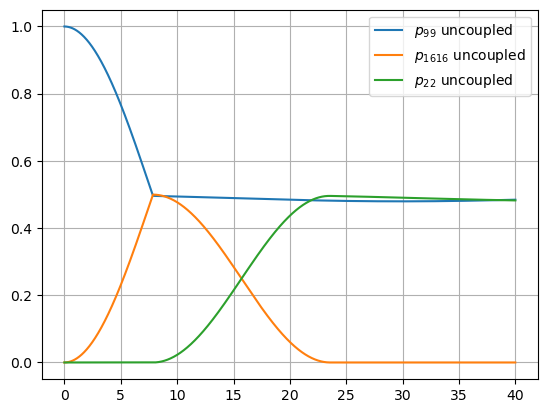

In [77]:
from matplotlib import pyplot as plt
plt.plot(t, pops_uncoupled[:,8], label="$p_{99}$ uncoupled")
plt.plot(t, pops_uncoupled[:,16], label="$p_{1616}$ uncoupled")
plt.plot(t, pops_uncoupled[:,2], label="$p_{22}$ uncoupled")
plt.grid()
#plt.xlim(10,20)
plt.legend()
plt.show()